## todo
- Split training/evaluating samples
- training with GPU
- distributed learning with plural GPU

## 0.0 library setting

In [1]:
import sys
import cntk as C
import numpy as np
from numpy.random import rand, randint #For selecting samples
import matplotlib.pyplot as plt

np.random.seed(0) ## For reproductivity

## 1.0 data generation
We use `linear regression` model in order to understand basic CNTK features. Here's a description, which we'll use:

|variables|description|range|
|:--|--:|:--:|
|$x$|explanatory variable|$0 \sim 10000$ with random noise|
|$y$|target variable|$1 \sim 20001$ with random noise|

Relation of $x$ and $y$: $y=2x+1+r$, where $r$ is random noise between $0$ and $1$. 

Also, $x$, $y$ are noted as $feature$, $label$ respectively in accordance with usual machine-learning context. We use both notations in this notebook.

In [2]:
# Create the feature and the label data. For our toy example the features/labels represent a simple line passing through the origin
total_sample_size = 10000

## The reason why we use `reshape` comes from training method.
features = np.array([i + rand() for i in range(total_sample_size)]).reshape(total_sample_size, 1)
labels = np.array([2*i + 1 + rand() for i in range(total_sample_size)]).reshape(total_sample_size, 1)

Let's see a few samples:

In [3]:
print("features :", features[0:5,:].T)
print("labels   :", labels[0:5,:].T)

features : [[0.5488135  1.71518937 2.60276338 3.54488318 4.4236548 ]]
labels   : [[1.74826798 3.18020271 5.38902314 7.03760018 9.01178774]]


In [4]:
### Extract some samples
def generate_random_data_sample(total_sample_size, sample_size, features, labels):
    '''
    Arguments:
        total_sample_size: Total numbers of samples
        sample_size: sample number to be extracted
        features: population for explanatory variable
        labels: population for target variable
    
    Return
        features, labels to be extracted
    '''
    ## Define the element numbers to extract
    index = randint(0, total_sample_size, sample_size)
    ## Extract both features, labels aligned to the element numbers defined above
    return features[index, :], labels[index, :]

## 1.1 Visualize samples

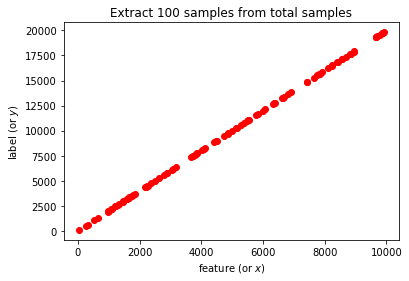

In [5]:
## Extract 100 samples
features_sample, labels_sample = generate_random_data_sample( 
    total_sample_size=total_sample_size, 
    sample_size=100, 
    features=features, 
    labels=labels)

## Visualize
plt.scatter(features_sample, labels_sample, c='r')
plt.xlabel("feature (or $x$)")
plt.ylabel("label (or $y$)")
plt.title("Extract 100 samples from total samples")
plt.show()

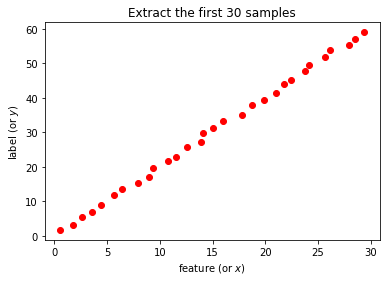

In [6]:
## Visualize the first 30 samples
plt.scatter(features[0:30], labels[0:30], c='r')
plt.xlabel("feature (or $x$)")
plt.ylabel("label (or $y$)")
plt.title("Extract the first 30 samples")
plt.show()

## 2.0 Define model structure

In our case, dimensions of input, output are both 1. ALso, in usual Neural Network terminology, we use $y = Wx + b$. In our case, $W, b$ correspond to $2, 1$ for each:

|variables|description|
|:--:|:--|
|$x$|explanatory variable|
|$y$|target variable|
|$W$|weight|
|$b$|bias|

With the setting as above, we may infer $W$ and $b$ with observations provided in `1.0 data generation`. 

In [7]:
# Define the network as a single node with no activation function
input_dim = 1
num_outputs = 1
input = C.input_variable(input_dim, np.float32)
label = C.input_variable(num_outputs, np.float32)

Training procedure means adjusting parameters $W$, $b$, and we'll use `parameter` method in CNTK:

In [8]:
# Define a dictionary to store the model parameters
mydict = {}
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    ## Define weight W
    weight_param = C.parameter(shape=(input_dim, output_dim))
    ## Define bias b
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    ## Wx + b. Pay attention to the order of variables!!
    return bias_param + C.times(input_var, weight_param)

$z$ is used as inferred result with parameter $W$, $b$.

In [9]:
## Define model structure
z = linear_layer(input, num_outputs)

## 2.1 Define loss function

`loss` is used in training, `eval_error` for evaluating. In our case, we use squared error, which is commonly used as regression model.

In [10]:
# Setup loss and evaluation functions
loss = C.squared_error(z, label)
eval_error = C.squared_error(z, label)

## 2.2 Set training parameters

- `learning_rate` means how fast the learning speed is. It sets bigger, the convergence is faster theoretically, But, it's defined as very small value, in usual cases.


- `lr_schedule` defines learning rate with entire training procedure. In our case, it's fixed as `learning_rate`. We can set it like `0.01` in the first iteration, `0.001` as the second, etc..

In [11]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.0000000001
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.sample) 

## 2.3 Define learner (how our algorithm optimizes the parameters)

- `learner` defines how our algorithm optimizes parameters. 
    - `sgd`: Optimize algorithm(Stochastic Gradient Descent)
    - `z.parameters`: Adjusted parameters, where are $W$, $b$ in our situation.
    - `lr_schedule`: How fast the learning speed is?

In [12]:
learner = C.sgd(z.parameters, lr_schedule)

- `trainer`: It encapsulates the overall training process and employs one or more learners to tune the parameters of a specified model using gradients of parameters w.r.t. a training objective.

In [13]:
trainer = C.Trainer(z, (loss, eval_error), [learner])

## 2.4 Define progress printer

Usually, the training cycle of deep learning continues very long time, and the following function enables us to confirm the situations.

In [14]:
# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))

    return mb, training_loss, eval_error

In [15]:
# Initialize the parameters for the trainer
minibatch_size = 50
num_samples_to_train = 5000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

# Run the trainer and perform model training
training_progress_output_freq = 10

### prerequisites with mathematical formulation
Remember that we selected squared error as loss function, we note it as $E(W, b)$:

$$
\begin{eqnarray}
E(W, b) := \sum_{j=1}^N(y_j-wx_j-b)^2
\end{eqnarray}
$$

where each variable is defined as follows:

|variables|description|
|:--:|:--|
|$N$|Number of samples|
|$x_j$|samples of explanatory variable|
|$y_j$|samples of target variable|
|$W$|weight|
|$b$|bias|

We think about the following graddients with `learning_rate`, indeed.

### gradient of $W$: 
$$
\begin{eqnarray}
\frac{\partial E}{\partial W} &=& \sum_j \frac{\partial}{\partial W}(y_j-Wx_j-b)^2 \\
&=& \sum_j 2\times (y_j-Wx_j-b) \times (-x_j) \\
&=& -2\times \sum_j (y_j-Wx_j-b)\times x_j
\end{eqnarray}
$$

The gradient $\frac{\partial E}{\partial W}$(precisely, multipled by `learning_rate`) is enough large to converge rather fast. This is because the term $(y_j-Wx_j-b)\times x_j$ is large as a whole, due to the fact some $x_j$ are large even if the term $(y_j-Wx_j-b)$ is nearly $0$. 

### gradient of $b$:

On the other hand, in caluculating the gradient with the direction of $b$, 
$$
\begin{eqnarray}
\frac{\partial E}{\partial b} &=& \sum_j \frac{\partial}{\partial b}(y_j-Wx_j-b)^2 \\
&=& \sum_j 2\times (y_j-Wx_j-b) \times (-1) \\
&=& -2\times \sum_j (y_j-Wx_j-b)
\end{eqnarray}
$$
Roughly speaking the term $y_j-Wx_j-b$(precisely, multipled by `learning_rate`) is almost $0$, i.e. the convergence speed is much slow, if we use gradient-like algorithm.

In [16]:
def gradient_W(features, labels, weight, bias):
    return -2 * np.sum([(label- weight * feature - bias) * feature for (feature, label) in  np.c_[features, labels]]) * learning_rate
    
def gradient_b(features, labels, weight, bias):
    return -2 * np.sum([(label- weight * feature - bias) for (feature, label) in  np.c_[features, labels]]) * learning_rate

In [17]:
## Prepare parameters, which we can see how the parameters are optimized.
W_values, b_values, W_gradients, b_gradients = [], [], [], []

## Training process
for i in range(0, num_minibatches_to_train):   
    ## Extract training data
    feature_samples, label_samples = generate_random_data_sample(
        total_sample_size=total_sample_size, 
        sample_size=minibatch_size, 
        features=features, 
        labels=labels)
    
    ## Train
    trainer.train_minibatch({input : feature_samples, label : label_samples})
    ## Progress print
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)

    ## Store weight, bias for chasing afterward
    W_values.append(mydict['w'].value)
    b_values.append(mydict['b'].value)
    ## Store gradient of weight, bias for chasing afterward
    W_gradients.append(
        gradient_W(
            features=feature_samples
            ,labels=label_samples
            ,weight=mydict['w'].value
            ,bias=mydict['b'].value   
        )
    )
    b_gradients.append(
        gradient_b(
            features=feature_samples
            ,labels=label_samples
            ,weight=mydict['w'].value
            ,bias=mydict['b'].value    
        )
    )

c:\users\kyiwasak\appdata\local\continuum\anaconda2\envs\py35\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
c:\users\kyiwasak\appdata\local\continuum\anaconda2\envs\py35\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input4") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Minibatch: 0, Loss: 132619970.5600, Error: 132619970.56
Minibatch: 10, Loss: 26365.1650, Error: 26365.17
Minibatch: 20, Loss: 3.7759, Error: 3.78
Minibatch: 30, Loss: 0.6252, Error: 0.63
Minibatch: 40, Loss: 0.4678, Error: 0.47
Minibatch: 50, Loss: 0.5455, Error: 0.55
Minibatch: 60, Loss: 0.5521, Error: 0.55
Minibatch: 70, Loss: 0.5407, Error: 0.54
Minibatch: 80, Loss: 0.4321, Error: 0.43
Minibatch: 90, Loss: 0.4642, Error: 0.46


## 3.0 Confirm final parameter set

In [18]:
print("pre-defined weight: 2,  adjusted weight: ", mydict['w'].value[0][0])
print("pre-defined bias  : 1,  adjusted bias  : ", mydict['b'].value[0])

pre-defined weight: 2,  adjusted weight:  2.0000784
pre-defined bias  : 1,  adjusted bias  :  0.00029361498


## 3.1 Confirm how the parameters converge

We find that weight $W$ converges into $2$, but the convergence of bias $b$ to $1$ is very slow in the following plot:

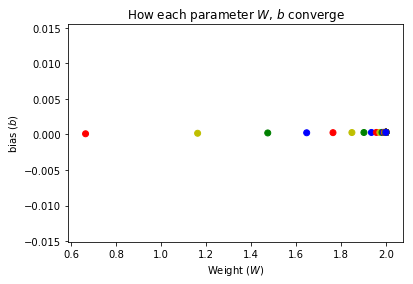

In [19]:
plt.scatter(W_values, b_values, c='rygb')
plt.xlabel('Weight ($W$)')
plt.ylabel('bias ($b$)')
plt.title('How each parameter $W$, $b$ converge')
plt.show()

We see the gradient $\frac{\partial E}{\partial W}$ multipled by `learning_rate` converge gradually. By contrast, $\frac{\partial E}{\partial b}$ multipled by `learning_rate` are almost $0$.

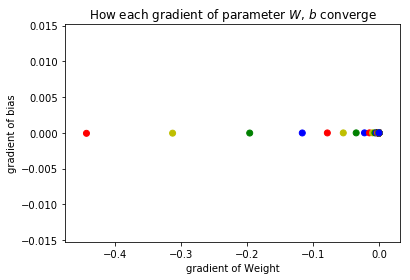

In [20]:
plt.scatter(W_gradients, b_gradients, c='rygb')
plt.xlabel('gradient of Weight')
plt.ylabel('gradient of bias')
plt.title('How each gradient of parameter $W$, $b$ converge')
plt.show()